In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.stats import pearsonr, spearmanr, kruskal
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder


In [2]:
# Set main directory
os.chdir("/Users/giandomenico/Documents/SAPIENZA/AR/MiC/Ferrara")
# set plotting settings
sns.set_theme(context='paper', style="whitegrid", palette="husl", font='arial', font_scale=1.2)

plt.rcParams.update({
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 11
    })


In [3]:
# Load datasets
filepath = 'PS_vs_Geo/buildings_bbcc_Ferrara_def3857_intersect_sampled.gpkg'
data = gpd.read_file(filepath)



data.columns

Index(['codice', 'nome', 'tipo_tutel', 'tipo_propr', 'categoria', 'eta',
       'eta_attest', 'stato', 'lon', 'lat', 'x', 'y', 'etichetta',
       'Interventi', 'Data inizi', 'Data fine', 'Ind_danno', 'note', 'Descr',
       'ASC_VEL_median', 'ASC_VEL_stdev', 'ASC_VEL_min', 'ASC_VEL_max',
       'ASC_CUM_median', 'ASC_CUM_stdev', 'ASC_CUM_min', 'ASC_CUM_max',
       'DESC_VEL_median', 'DESC_VEL_stdev', 'DESC_VEL_min', 'DESC_VEL_max',
       'DESC_CUM_median', 'DESC_CUM_stdev', 'DESC_CUM_min', 'DESC_CUM_max',
       'UD_VEL_median', 'UD_VEL_stdev', 'UD_VEL_min', 'UD_VEL_max',
       'geometry'],
      dtype='object')

In [4]:
# select important columns only
cols_to_keep = ['codice', 'Descr', 'ASC_VEL_median', 'ASC_VEL_stdev', 'ASC_VEL_min', 'ASC_VEL_max',
       'ASC_CUM_median', 'ASC_CUM_stdev', 'ASC_CUM_min', 'ASC_CUM_max',
       'DESC_VEL_median', 'DESC_VEL_stdev', 'DESC_VEL_min', 'DESC_VEL_max',
       'DESC_CUM_median', 'DESC_CUM_stdev', 'DESC_CUM_min', 'DESC_CUM_max',
       'UD_VEL_median', 'UD_VEL_stdev', 'UD_VEL_min', 'UD_VEL_max',
       'geometry']

data_clean = data[cols_to_keep]

# drop nan
data_clean = data_clean.dropna()

data_clean.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 664 entries, 0 to 698
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   codice           664 non-null    object  
 1   Descr            664 non-null    object  
 2   ASC_VEL_median   664 non-null    float64 
 3   ASC_VEL_stdev    664 non-null    float64 
 4   ASC_VEL_min      664 non-null    float64 
 5   ASC_VEL_max      664 non-null    float64 
 6   ASC_CUM_median   664 non-null    float64 
 7   ASC_CUM_stdev    664 non-null    float64 
 8   ASC_CUM_min      664 non-null    float64 
 9   ASC_CUM_max      664 non-null    float64 
 10  DESC_VEL_median  664 non-null    float64 
 11  DESC_VEL_stdev   664 non-null    float64 
 12  DESC_VEL_min     664 non-null    float64 
 13  DESC_VEL_max     664 non-null    float64 
 14  DESC_CUM_median  664 non-null    float64 
 15  DESC_CUM_stdev   664 non-null    float64 
 16  DESC_CUM_min     664 non-null    flo

In [5]:
data_clean.Descr.value_counts()

argille e limi di deposito interalveo              255
Limi con sabbie di  argine e venaglio di rotta     244
Sabbie di riempimento di canale fluviale           115
Sabbie limose di riempimento di canale fluviale     39
Sabbie e limi di riempimento di canale fluviale      7
Lmi con sabbie di argine e venaglio di rotta         2
Limi con sabbie di argine venaglio da rotta          1
Argille e limi di deposito interalvei                1
Name: Descr, dtype: int64

### Map lithology values

In [6]:
# Define the mapping dictionary
mapping = {
    'argille e limi di deposito interalveo': 'Floodplain deposits',
    'Argille e limi di deposito interalvei': 'Floodplain deposits',
    'Limi con sabbie di  argine e venaglio di rotta': 'Levee and crevasse splay deposits',
    'Lmi con sabbie di argine e venaglio di rotta': 'Levee and crevasse splay deposits',
    'Limi con sabbie di argine venaglio da rotta': 'Levee and crevasse splay deposits',
    'Sabbie di riempimento di canale fluviale': 'Channel fill deposits',
    'Sabbie limose di riempimento di canale fluviale': 'Channel fill deposits',
    'Sabbie e limi di riempimento di canale fluviale': 'Channel fill deposits'
}

In [7]:
# Apply the mapping to the column
data_clean['Lithology'] = data_clean['Descr'].map(mapping)

# Print value counts of the new column to verify the result
print(data_clean['Lithology'].value_counts())

Floodplain deposits                  256
Levee and crevasse splay deposits    247
Channel fill deposits                161
Name: Lithology, dtype: int64


In [8]:
# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder and transform the 'Lithology' column to get encoded labels
data_clean['Lithology_enc'] = encoder.fit_transform(data_clean['Lithology'])

# Print the modified DataFrame
print(data_clean.Lithology_enc.value_counts())

1    256
2    247
0    161
Name: Lithology_enc, dtype: int64


# Hypotesis Testing

In [28]:
# Set ASC, DESC, UD variables
asc_vel = 'ASC_VEL_median'
desc_vel = 'DESC_VEL_median'
ud_vel = 'UD_VEL_median'
asc_cum = 'ASC_CUM_median'
desc_cum = 'DESC_CUM_median'

# Calculate the mean, minimum, and maximum values for each group
asc_velocity_stats = data_clean.groupby('Lithology')[asc_vel].agg(['median', 'min', 'max', 'std']).reset_index()
desc_velocity_stats = data_clean.groupby('Lithology')[desc_vel].agg(['median', 'min', 'max', 'std']).reset_index()
ud_disp_stats = data_clean.groupby('Lithology')[ud_vel].agg(['median', 'min', 'max', 'std']).reset_index()

# Calculate the correlation between displacement and other geological attributes
correlation = pearsonr(data_clean['Lithology_enc'], data_clean[ud_vel])
print(correlation)

ordinal = [asc_vel, desc_vel, ud_vel, asc_cum, desc_cum]
nominal = 'Lithology'

# ANOVA/Kruskal-Wallis test for deformation rates across different geological types
for v in ordinal:
    groups = [data_clean[v][data_clean[nominal] == gt] for gt in data_clean[nominal].unique()]
    stat, p_value = kruskal(*groups)
    print(f'Kruskal-Wallis test ({v}): Stat={stat}, P-value={p_value}')

PearsonRResult(statistic=0.01749921355760283, pvalue=0.6526325374801805)
Kruskal-Wallis test (ASC_VEL_median): Stat=43.87831155632179, P-value=2.9644607728520575e-10
Kruskal-Wallis test (DESC_VEL_median): Stat=80.22816232617421, P-value=3.790320237114629e-18
Kruskal-Wallis test (UD_VEL_median): Stat=76.98331173290669, P-value=1.9199338156797712e-17
Kruskal-Wallis test (ASC_CUM_median): Stat=31.97898329928012, P-value=1.1372396895679716e-07
Kruskal-Wallis test (DESC_CUM_median): Stat=36.288626113001946, P-value=1.3183325092432723e-08


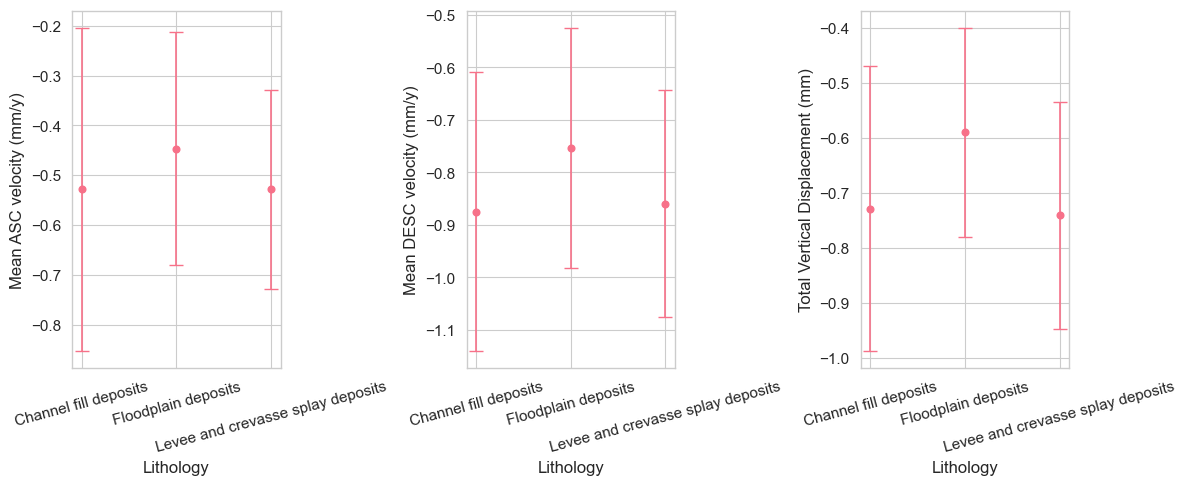

In [24]:
# Plot the scatter points with error bars
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

ax1.errorbar(asc_velocity_stats['Lithology'], asc_velocity_stats['median'], yerr=asc_velocity_stats['std'], fmt='o', capsize=5)
ax2.errorbar(desc_velocity_stats['Lithology'], desc_velocity_stats['median'], yerr=desc_velocity_stats['std'], fmt='o', capsize=5)
ax3.errorbar(ud_disp_stats['Lithology'], ud_disp_stats['median'], yerr=ud_disp_stats['std'], fmt='o', capsize=5)

ax1.set_xlabel('Lithology')
ax1.set_ylabel('Mean ASC velocity (mm/y)')
ax2.set_xlabel('Lithology')
ax2.set_ylabel('Mean DESC velocity (mm/y)')
ax3.set_xlabel('Lithology')
ax3.set_ylabel('Total Vertical Displacement (mm)')

for tick in ax1.get_xticklabels():
    tick.set_rotation(15)
for tick in ax2.get_xticklabels():
    tick.set_rotation(15)
for tick in ax3.get_xticklabels():
    tick.set_rotation(15)
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.show()

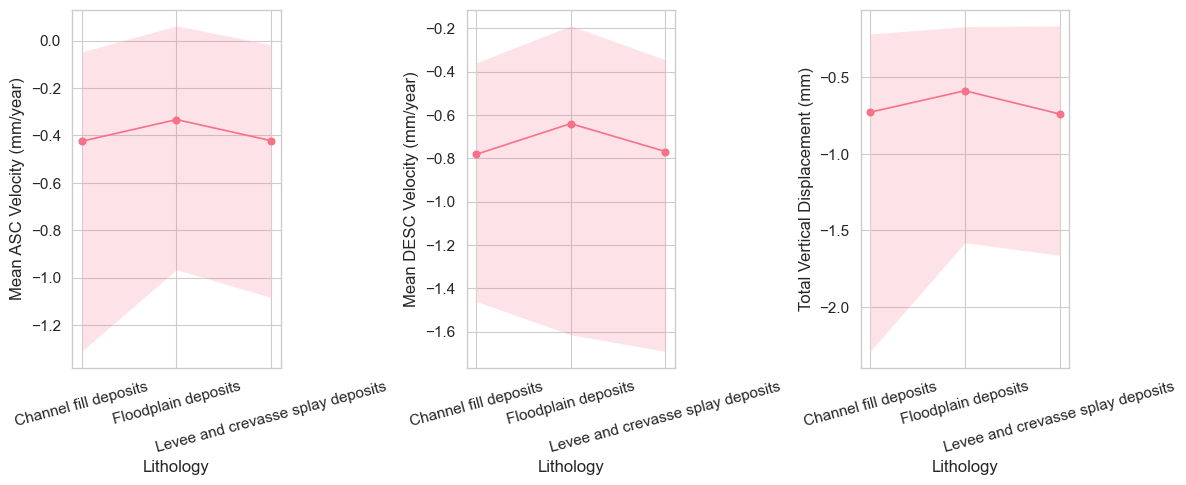

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))

ax1.plot(asc_velocity_stats['Lithology'], asc_velocity_stats['median'], 'o-')
ax1.fill_between(asc_velocity_stats['Lithology'], asc_velocity_stats['min'], asc_velocity_stats['max'], alpha=0.2)

ax2.plot(desc_velocity_stats['Lithology'], desc_velocity_stats['median'], 'o-')
ax2.fill_between(desc_velocity_stats['Lithology'], desc_velocity_stats['min'], desc_velocity_stats['max'], alpha=0.2)

ax3.plot(ud_disp_stats['Lithology'], ud_disp_stats['median'], 'o-')
ax3.fill_between(ud_disp_stats['Lithology'], ud_disp_stats['min'], ud_disp_stats['max'], alpha=0.2)

ax1.set_xlabel('Lithology')
ax1.set_ylabel('Mean ASC Velocity (mm/year)')
ax1.set_xticks(np.arange(len(asc_velocity_stats['Lithology'])))
ax1.set_xticklabels(asc_velocity_stats['Lithology'], rotation=15)

ax2.set_xlabel('Lithology')
ax2.set_ylabel('Mean DESC Velocity (mm/year)')
ax2.set_xticks(ud_disp_stats['Lithology'])
ax2.set_xticklabels(ud_disp_stats['Lithology'], rotation=15)

ax3.set_xlabel('Lithology')
ax3.set_ylabel('Total Vertical Displacement (mm)')
ax3.set_xticks(ud_disp_stats['Lithology'])
ax3.set_xticklabels(ud_disp_stats['Lithology'], rotation=15)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

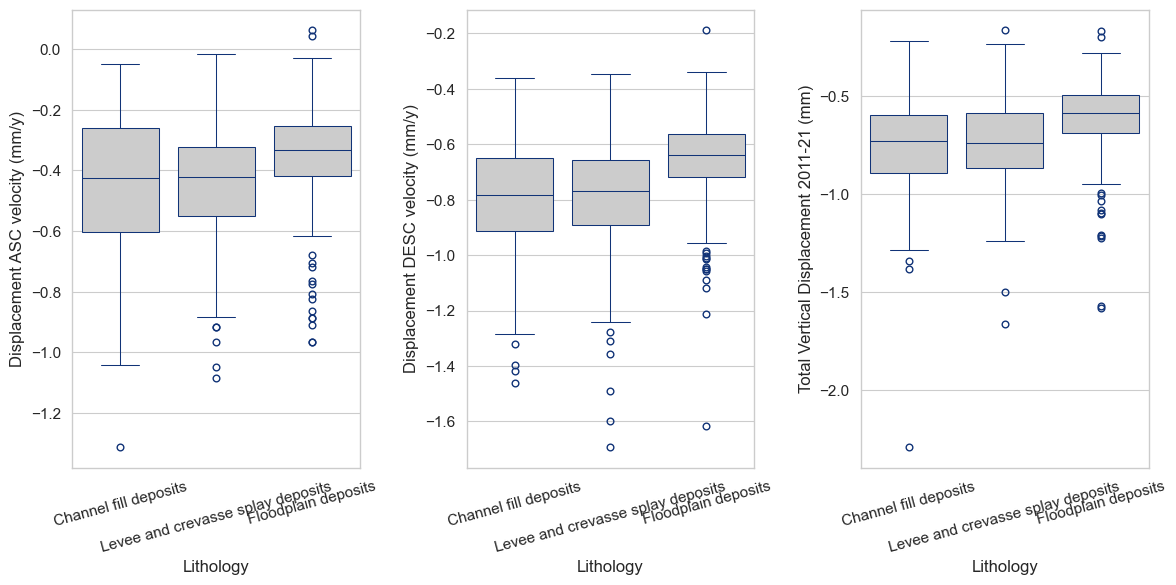

In [34]:
X = 'Lithology'
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

ax1 = sns.boxplot(data=data_clean, x=X, y=asc_vel, color=".8", linecolor="#137", linewidth=.75, ax=ax1)
ax2 = sns.boxplot(data=data_clean, x=X, y=desc_vel, color=".8", linecolor="#137", linewidth=.75, ax=ax2)
ax3 = sns.boxplot(data=data_clean, x=X, y=ud_vel, color=".8", linecolor="#137", linewidth=.75, ax=ax3)

ax1.set_xlabel("Lithology")
ax1.set_ylabel("Displacement ASC velocity (mm/y)")
for tick in ax1.get_xticklabels():
    tick.set_rotation(15)

ax2.set_xlabel("Lithology")
ax2.set_ylabel("Displacement DESC velocity (mm/y)")
for tick in ax2.get_xticklabels():
    tick.set_rotation(15)

ax3.set_xlabel("Lithology")
ax3.set_ylabel("Total Vertical Displacement 2011-21 (mm)")
for tick in ax3.get_xticklabels():
    tick.set_rotation(15)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

# Display the plot
plt.show()

## Cluster analysis

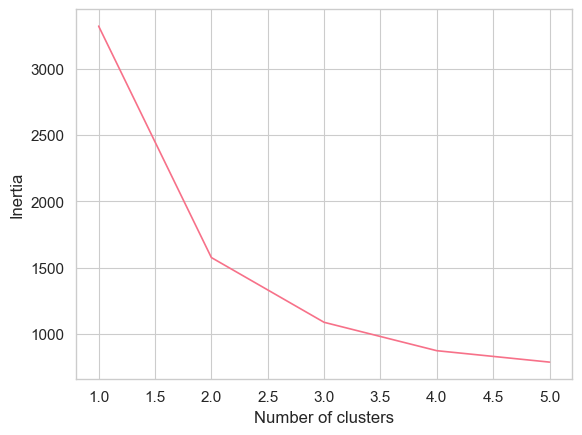

In [58]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the relevant features
# features = data_clean[[asc_vel, desc_vel, ud_vel, asc_cum, desc_cum]]
features = data_clean[[asc_cum, desc_cum, ud_vel]]


# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters
inertia = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 6), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [55]:
# Based on the elbow plot, choose the optimal number of clusters (e.g., 2)
n_clusters = 3

# Perform K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add the cluster labels to the original dataframe
data_clean['Cluster'] = clusters

# Print the clusters
print(data_clean.groupby('Cluster').agg({asc_vel: 'mean', desc_vel:'mean', ud_vel: 'mean',
                                         asc_cum:'mean', desc_cum:'mean', 
                                         'Lithology': 'nunique'}))

         ASC_VEL_median  DESC_VEL_median  UD_VEL_median  ASC_CUM_median  \
Cluster                                                                   
0             -0.764797        -1.097196      -1.110216       -9.105604   
1             -0.261452        -0.593823      -0.521383       -2.916131   
2             -0.466219        -0.801584      -0.769574       -5.494687   

         DESC_CUM_median  Lithology  
Cluster                              
0             -14.692664          3  
1              -8.587037          3  
2             -11.092101          3  


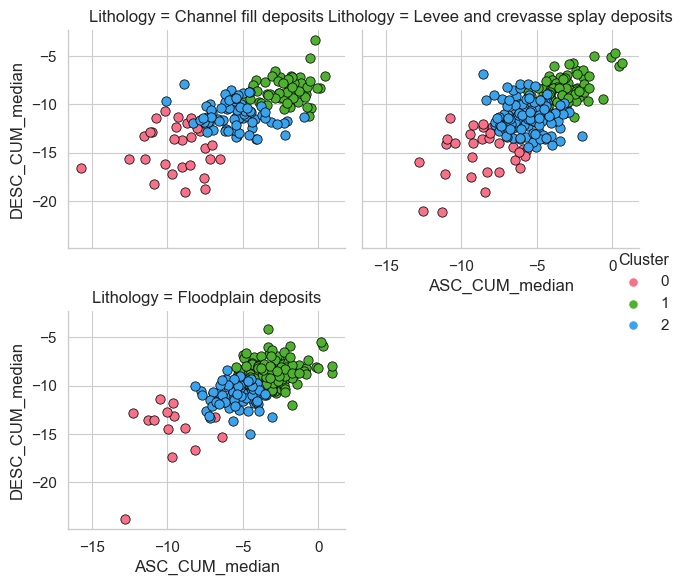

In [57]:
palette = sns.color_palette("husl", n_colors=len(data_clean['Cluster'].unique()))

# Create scatterplot with columns based on 'Litologia' and colored by 'cluster'
g = sns.FacetGrid(data_clean, col="Lithology", hue="Cluster", col_wrap=2, palette=palette, height=3, aspect=1)
g.map(sns.scatterplot, asc_cum, desc_cum, marker="o", s=45)
g.add_legend(title="Cluster")

# Set marker edge color for all scatter points
for ax in g.axes.flat:
    for collection in ax.collections:
        if isinstance(collection, matplotlib.collections.PathCollection):
            collection.set_edgecolor("black")

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()

plt.show()